In [21]:
import skimage.io as skio
import matplotlib.pyplot as plt
import numpy as np
import skimage
import ipywidgets as wdg
import cv2
from skimage.morphology import disk


In [84]:
img_base = skio.imread("base_1.jpg")
ex1 = skio.imread("ex2.jpg")

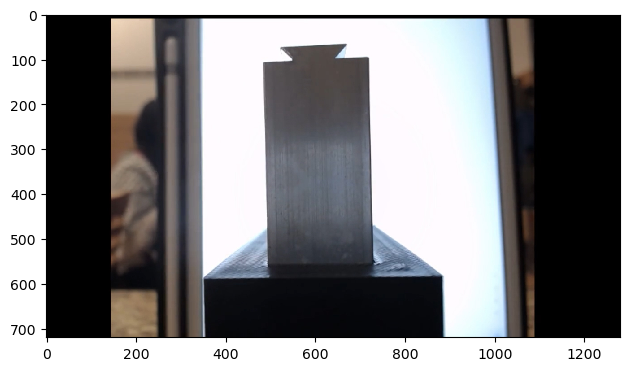

In [122]:
skio.imshow(img_base)

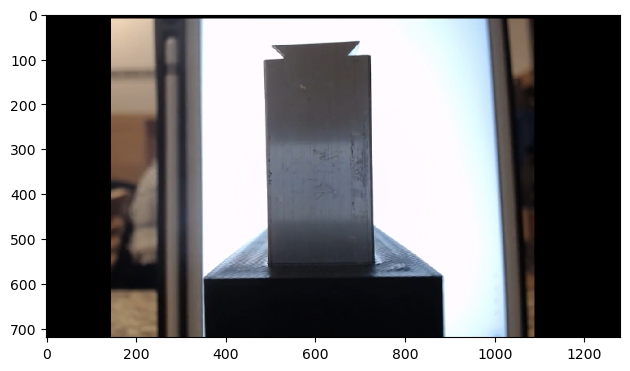

In [123]:
skio.imshow(ex1)

In [61]:
def compare(img_base, ex1,threshold = 170):
    """
    performs an intersection over union between two images and returns a visualization of the operation and the value of IOU
    """
    #final canvas that will display result
    canvas = np.zeros_like(img_base)
    
    #using blue channel since it gives best separation between LED light in background and part
    img_base = img_base[:, :, 2]
    ex1 = ex1[:, :, 2]
    
    base_T = 255 - ((img_base > threshold) * 255)
    ex1_T = 255 - ((ex1 > threshold) * 255)
    
    #creates a crop window where operation will occur in
    window = np.zeros_like(base_T)
    window[50:450,400 :800] = 1
    base_T = window * base_T
    ex1_T = window * ex1_T
    
    #populates canvas with RGB values of IOT
    canvas[:, :, 1] = base_T
    canvas[:, :, 2] = base_T
    canvas[:, :, 0] = ex1_T
    
    #Using thresholding 
    slicable = (skimage.color.rgb2gray(canvas) * 255).astype(np.uint8)
    more = slicable == 54
    less = slicable == 200
    
    #calculating union
    b = np.sum(np.logical_or(base_T, more))
    a = np.sum(base_T > 0)
    accuracy = a / b
    return canvas, accuracy

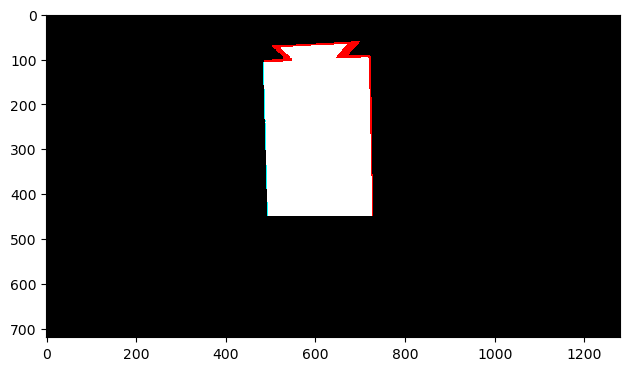

In [62]:
skio.imshow(compare(img_base,ex1)[0])

In [118]:

def compare_edges(img_base, ex1, threshold = 0.05):
    """
    Takes two images as input, one is img_base: reference part, and other is ex1: measured part. returns final visualization of  flaws detected
    along with percentage of flaws.
    """
    
    def canny(base,sigma = 2):
        """
        returns a dilated canny edge detection of base
        """
        canny_edges = skimage.feature.canny(base, sigma = sigma)
        eroded = skimage.morphology.dilation(canny_edges,disk(8))
        return eroded
    
    def find_edges(image):
        """
        normalizes an image and performs farid edge detection
        """
        gray = (image * 255).astype(np.uint8)
        mask = gray < 150
        gray = skimage.exposure.equalize_hist(gray)
        gray = gray * mask
        gray = skimage.exposure.adjust_gamma(gray, 2.6, 5)
        gray = skimage.filters.median(gray, disk(2))
        edges = skimage.filters.farid(gray) > threshold
        return edges
    
    #converts images to grayscale if needed.
    if img_base.shape[-1] == 3:
            img_base = skimage.color.rgb2gray(img_base)
            ex1 = skimage.color.rgb2gray(ex1)
    
    #creates cropping window
    window = np.zeros_like(img_base)
    window[50:450,400 :800] = 1
    
    img_base = (canny(img_base) * 255) * window
    ex1 = (find_edges(ex1) * 255) * window

    #subtracts major edges in base using canny from the fraid edges found in ex1
    final = np.clip(ex1 - img_base, a_min=0, a_max=255) > 0
    total = np.sum(img_base < 150)
    numerator = np.sum(final)
    if total > 0:
        flaws_detected = numerator / total
    else:
        flaws_detected = 0  # Avoid division by zero
    return final, flaws_detected

In [119]:
edges_detected, flaws_percentage = compare_edges(img_base,ex1)


0.2902174694762698 %


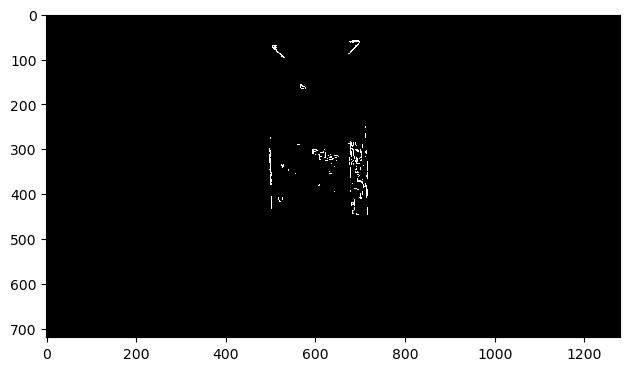

In [121]:
skio.imshow(edges_detected)
print(flaws_percentage*100,"%")